# Hand Gesture Recognition


The original MNIST image dataset of handwritten digits is a popular benchmark for image-based machine learning methods but researchers have renewed efforts to update it and develop drop-in replacements that are more challenging for computer vision and original for real-world applications. As noted in one recent replacement called the Fashion-MNIST dataset, the Zalando researchers quoted the startling claim that "Most pairs of MNIST digits (784 total pixels per sample) can be distinguished pretty well by just one pixel". To stimulate the community to develop more drop-in replacements, the Sign Language MNIST is presented here and follows the same CSV format with labels and pixel values in single rows. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).

The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity. The modification and expansion strategy was filters ('Mitchell', 'Robidoux', 'Catrom', 'Spline', 'Hermite'), along with 5% random pixelation, +/- 15% brightness/contrast, and finally 3 degrees rotation. Because of the tiny size of the images, these modifications effectively alter the resolution and class separation in interesting, controllable ways.

This dataset was inspired by the Fashion-MNIST 2 and the machine learning pipeline for gestures by Sreehari 4.

A robust visual recognition algorithm could provide not only new benchmarks that challenge modern machine learning methods such as Convolutional Neural Nets but also could pragmatically help the deaf and hard-of-hearing better communicate using computer vision applications. The National Institute on Deafness and other Communications Disorders (NIDCD) indicates that the 200-year-old American Sign Language is a complete, complex language (of which letter gestures are only part) but is the primary language for many deaf North Americans. ASL is the leading minority language in the U.S. after the "big four": Spanish, Italian, German, and French. One could implement computer vision in an inexpensive board computer like Raspberry Pi with OpenCV, and some Text-to-Speech to enabling improved and automated translation applications.


**Source = [Kaggle](https://www.kaggle.com/datamunge/sign-language-mnist)**

### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [3]:
import os

### Load Dataset

In [5]:
test_df = pd.read_csv("sign_mnist_test.csv")
train_df = pd.read_csv("sign_mnist_train.csv")

In [14]:
def show_img(img, df):
    
    #Take the label
    label = test_df["label"][img]
    
    #Take the pixels
    pixels = test_df.iloc[img, 1:]
    
    #The pixel intensity values are integers from 0 to 255
    pixels = np.array(pixels, dtype='uint8')
    
    #Reshape the array into 28x28 array (2-dimensional array)
    pixels = pixels.reshape((28, 28))
    
    #Plot
    plt.title("Label Is {label}".format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

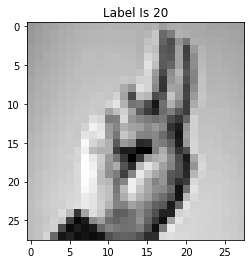

In [21]:
show_img(50,test_df)

In [23]:
#Extract Labels
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [25]:
#Label Binarizer

label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [26]:
x_train = train_df.values
x_test = test_df.values

In [27]:
#Normalization

x_train = x_train/255
x_test = x_test/255

In [28]:
#Reshape
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [29]:
# Data Augmentation

data_generator = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = False,
    vertical_flip = False

)

data_generator.fit(x_train)

### Build Model

In [30]:
model=Sequential()
model.add(Conv2D(75,(3,3),strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(50,(3,3),strides=1,padding='same',activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(25,(3,3),strides=1,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Flatten())
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=24,activation='softmax'))

### Compile Model

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Ser Learning Rate

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr = 0.00001)

### Train Model

In [33]:
model.fit(data_generator.flow(x_train, y_train, batch_size = 128), epochs = 20, validation_data = (x_test, y_test), callbacks = [learning_rate_reduction])

Epoch 1/20
215/215 [==============================] - 103s 309ms/step - loss: 1.7607 - accuracy: 0.4760 - val_loss: 4.1925 - val_accuracy: 0.0947
Epoch 2/20
215/215 [==============================] - 65s 303ms/step - loss: 0.2520 - accuracy: 0.9153 - val_loss: 1.2401 - val_accuracy: 0.5818
Epoch 3/20
215/215 [==============================] - 65s 304ms/step - loss: 0.1256 - accuracy: 0.9584 - val_loss: 0.0821 - val_accuracy: 0.9833
Epoch 4/20
215/215 [==============================] - 65s 301ms/step - loss: 0.0649 - accuracy: 0.9792 - val_loss: 0.1690 - val_accuracy: 0.9417
Epoch 5/20
215/215 [==============================] - 64s 300ms/step - loss: 0.0485 - accuracy: 0.9844 - val_loss: 0.0960 - val_accuracy: 0.9603

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/20
215/215 [==============================] - 59s 272ms/step - loss: 0.0268 - accuracy: 0.9923 - val_loss: 0.0171 - val_accuracy: 0.9940
Epoch 7/20
215/215 [============================

In [34]:
# Check Accuracy

model.evaluate(x_test, y_test)

225/225 [==============================] - 4s 16ms/step - loss: 6.3668e-04 - accuracy: 1.0000


[0.0006366824964061379, 1.0]

### Prediction Obtain

In [35]:
predictions = model.predict_classes(x_test)

for i in range(len(predictions)):
    if (predictions[i]>=9 or predictions[i]>=25):
        predictions[i]+=1
predictions[:5]

c:\users\nasir khan\appdata\local\programs\python\python39\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([ 6,  5, 10,  0,  3], dtype=int64)

### Save Model

In [36]:
model.save("Hand_Gesture_Recognition.h5")